In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
import torch
sys.path.append(os.path.dirname(os.path.join(os.getcwd()))) 
from data_utils.data_utils import DataUtils
from model.lstm import LSTM
from data_set.LSTMDataset import LSTMDataSet
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_interm = pd.read_csv('../dataset/sandp500/all_stocks_5yr.csv')
df_interm = df_interm[df_interm['Name'] == 'AAPL']
df_interm['date'] = pd.to_datetime(df_interm['date'], format="%Y/%m/%d")
df = df_interm[['date','close']]
df = df.set_index('date')

# ARIMA

In [3]:
logScale_df = np.log(df)
logScale_df_Shifting = logScale_df - logScale_df.shift()
logScale_df_Shifting.dropna(inplace=True)

def train_arima(p, d, q):
    model = ARIMA(logScale_df, order=(p,d,q))
    results_ARIMA = model.fit(disp=-1)
    return results_ARIMA

ARIMA_trained = train_arima(2, 1, 2)
predictions = pd.Series(ARIMA_trained.fittedvalues, copy=True)
predictions_cumulated = predictions.cumsum()
predictions_cumulated.head()
predictions_log_scale = pd.Series(logScale_df['close'].iloc[0], index=logScale_df.index)
predictions_log_scale = predictions_log_scale.add(predictions_cumulated, fill_value=0)
predictions_ARIMA = np.exp(predictions_log_scale)

# LSTM

In [4]:
training_set = torch.utils.data.TensorDataset(LSTMDataSet().X[:1000,:,:].float(), LSTMDataSet().Y[:1000].float())
training_generator = DataLoader(training_set, batch_size=700, shuffle=False)
validation_set = torch.utils.data.TensorDataset(LSTMDataSet().X[1000:,:,:].float(), LSTMDataSet().Y[1000:].float())
validation_generator = DataLoader(validation_set, batch_size=1000, shuffle=False)

model = LSTM()
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 50
hist_train, hist_val = np.empty(num_epochs), np.empty(num_epochs)

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    
    for X_train, Y_train in training_generator:
        Y_train_pred = model(X_train)
        train_loss = loss_fn(Y_train_pred, Y_train)
    
    with torch.set_grad_enabled(False):
        for X_val, Y_val in validation_generator:
            Y_val_pred = model(X_val)
            val_loss = loss_fn(Y_val_pred, Y_val)
    
    if epoch % 10 == 0 and epoch !=0:
        print("Epoch:", epoch, "|", "Training MSE Loss :", round(train_loss.item(), 10), "|", "Validation MSE Loss:", round(val_loss.item(), 10))
        
    hist_train[epoch], hist_val[epoch] = train_loss.item(), val_loss.item()
    
    # Backward pass
    train_loss.backward()

    # Update parameters
    optimizer.step()

Y = LSTMDataSet().Y.numpy()
Y_train_pred = model(LSTMDataSet().X[:1000,:,:].float())
Y_val_pred = model(LSTMDataSet().X[1000:,:,:].float())

Epoch: 10 | Training MSE Loss : 0.0163679663 | Validation MSE Loss: 0.1722848266
Epoch: 20 | Training MSE Loss : 0.0105382074 | Validation MSE Loss: 0.0766747221
Epoch: 30 | Training MSE Loss : 0.0085183308 | Validation MSE Loss: 0.0906899348
Epoch: 40 | Training MSE Loss : 0.0067479881 | Validation MSE Loss: 0.0695424974


# Résumé

In [5]:
lstm_pred = np.hstack((Y_train_pred.detach().numpy(), Y_val_pred.detach().numpy()))
lstm_pred.shape

(1199,)

In [6]:
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(df)

In [7]:
lstm_pred_transformed = transformer.inverse_transform(lstm_pred.reshape(-1, 1)).reshape(1, -1)

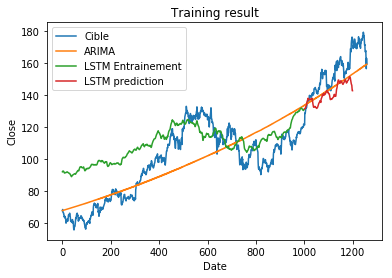

In [12]:
plt.plot(df.values, label='Cible')
plt.plot(predictions_ARIMA.values, label='ARIMA')
plt.plot(lstm_pred_transformed[0][:1000], label='LSTM Entrainement')
plt.plot(
    range(lstm_pred_transformed[0][:1000].shape[0] + 1, lstm_pred_transformed[0].shape[0]+1),
    lstm_pred_transformed[0][1000:], label='LSTM prediction'
)
plt.title('Training result')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()